# Chapter 4. Mastering Vectorized Backtesting
https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch04.html#idm45785387428584

covers the following types of strategies (refer also to “Trading Strategies”):

Simple moving averages (SMA) based strategies

    The basic idea of SMA usage for buy and sell signal generation is already decades old. SMAs are a major tool in the so-called technical analysis of stock prices. A signal is derived, for example, when an SMA defined on a shorter time window—say 42 days—crosses an SMA defined on a longer time window—say 252 days.
Momentum strategies

    These are strategies that are based on the hypothesis that recent performance will persist for some additional time. For example, a stock that is downward trending is assumed to do so for longer, which is why such a stock is to be shorted.
Mean-reversion strategies

    The reasoning behind mean-reversion strategies is that stock prices or prices of other financial instruments tend to revert to some mean level or to some trend level when they have deviated too much from such levels.


## Strategies Based on Simple Moving Averages



In [87]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                            index_col=0, parse_dates=True).dropna()
# raw.info()
data = pd.DataFrame(raw['EUR='])
data.rename(columns={'EUR=': 'price'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [88]:

data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()
data.dropna(inplace=True)
# data.tail()

# %matplotlib inline
# from pylab import mpl, plt
# mpl.rcParams['savefig.dpi'] = 300
# mpl.rcParams['font.family'] = 'serif'
# data.plot(title='EUR/USD | 42 & 252 days SMAs',
#           figsize=(10, 6));

market returns -0.1767305772293794
strategy returns 0.253120673154939
market gross returns 0.838005531883084
strategy gross returns 1.2880386991503012


<Axes: xlabel='Date'>

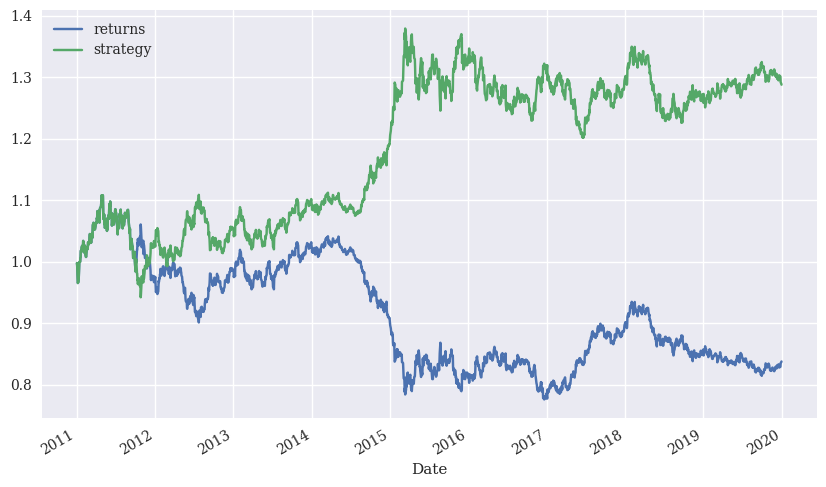

In [94]:

data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
# data['position'].plot(ylim=[-1.1, 1.1],
#                                title='Market Positioning',
#                                figsize=(10, 6));

# calculate the performance of the strategy
data['returns'] = np.log(data['price'] / data['price'].shift(1))
# data['returns'].hist(bins=35, figsize=(10, 6));

data['strategy'] = data['position'].shift(1) * data['returns']
returns = data[['returns', 'strategy']].sum()
print("market returns", returns["returns"])
print("strategy returns", returns["strategy"])
# calculate the gross performance
gross_performance = data[['returns', 'strategy']].sum().apply(np.exp)
print("market gross returns", gross_performance["returns"])
print("strategy gross returns", gross_performance["strategy"])

# plot gross performance
data[['returns', 'strategy']].cumsum(
                     ).apply(np.exp).plot(figsize=(10, 6))

max_drawdown 0.17779367070195895


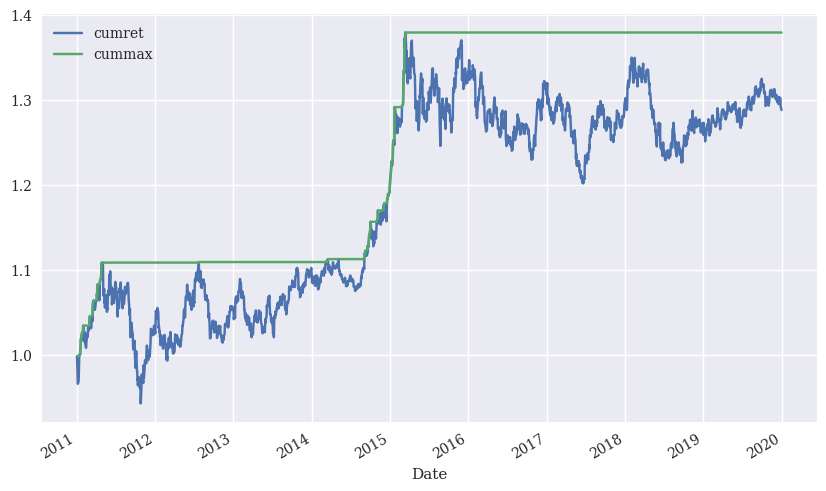

In [99]:
# gross performance over time
data['cumret'] = data['strategy'].cumsum().apply(np.exp)
# running maximum value of the gross performance
data['cummax'] = data['cumret'].cummax()
# Plots the two new columns
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6));

# max drawdown
drawdown = data['cummax'] - data['cumret']
max_drawdown = drawdown.max()
print("max_drawdown", max_drawdown)

In [105]:
import datetime
# determination of the longest drawdown period

# Where are the differences equal to zero?
temp = drawdown[drawdown == 0]
# Calculates the timedelta values between all index values
periods = (temp.index[1:].to_pydatetime() -
                    temp.index[:-1].to_pydatetime())
# Picks out the maximum timedelta value
periods.max()

datetime.timedelta(days=596)

### SMA Backtesting Class

(1.29, 0.45)
(0.97, 0.05)
(array([ 50., 236.]), 1.49)


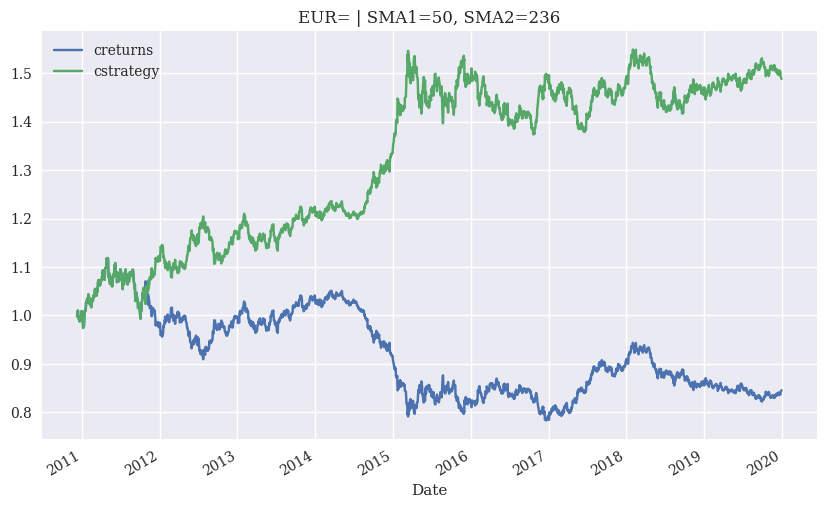

In [106]:
#
# Python Module with Class
# for Vectorized Backtesting
# of SMA-based Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from scipy.optimize import brute


class SMAVectorBacktester(object):
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        RIC symbol with which to work
    SMA1: int
        time window in days for shorter SMA
    SMA2: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    set_parameters:
        sets one or two new SMA parameters
    run_strategy:
        runs the backtest for the SMA-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    update_and_run:
        updates SMA parameters and returns the (negative) absolute performance
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''

    def __init__(self, symbol, SMA1, SMA2, start, end):
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['price'].rolling(self.SMA1).mean()
        raw['SMA2'] = raw['price'].rolling(self.SMA2).mean()
        self.data = raw

    def set_parameters(self, SMA1=None, SMA2=None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(
                self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()

    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,
                                               self.SMA1, self.SMA2)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))

    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns negative absolute performance
        (for minimazation algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)


if __name__ == '__main__':
    smabt = SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2020-12-31')
    print(smabt.run_strategy())
    smabt.set_parameters(SMA1=20, SMA2=100)
    print(smabt.run_strategy())
    print(smabt.optimize_parameters((30, 56, 4), (200, 300, 4)))
    smabt.plot_results()

## Strategies Based on Momentum

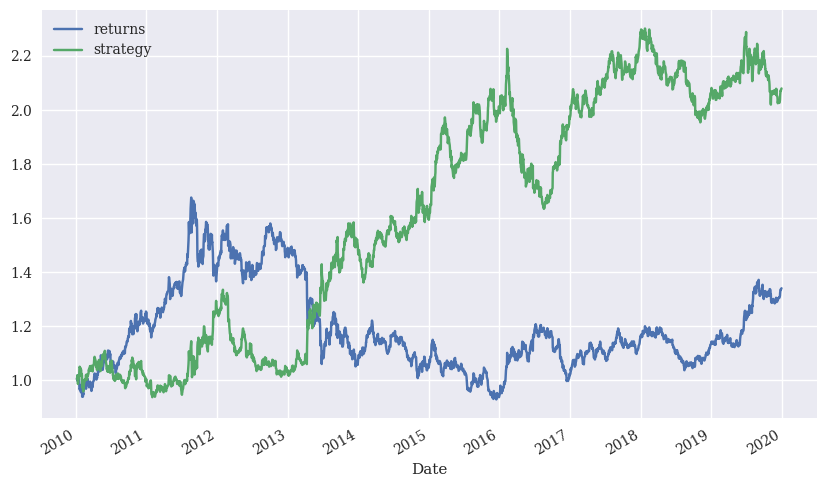

In [109]:
data = pd.DataFrame(raw['XAU='])
data.rename(columns={'XAU=': 'price'}, inplace=True)
data['returns'] = np.log(data['price'] / data['price'].shift(1))

# # The most simple time series momentum strategy is to buy the stock
# # if the last return was positive and to sell it if it was negative
# data['position'] = np.sign(data['returns'])
# data['strategy'] = data['position'].shift(1) * data['returns']
# data[['returns', 'strategy']].dropna().cumsum(
#                      ).apply(np.exp).plot(figsize=(10, 6));

# Using a rolling time window, the time series momentum strategy can
# be generalized to more than just the last return
data['position'] = np.sign(data['returns'].rolling(3).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6));

# the last two returns instead of three leads to a much worse performance


### Momentum Backtesting Class

Compared to the SMAVectorBacktester class, this one introduces two important generalizations: the fixed amount to be invested at the beginning of the backtesting period and proportional transaction costs to get closer to market realities cost-wise. In particular, the addition of transaction costs is important in the context of time series momentum strategies that often lead to a large number of transactions over time.

(20797.87, 7395.53)
(10749.4, -2652.93)


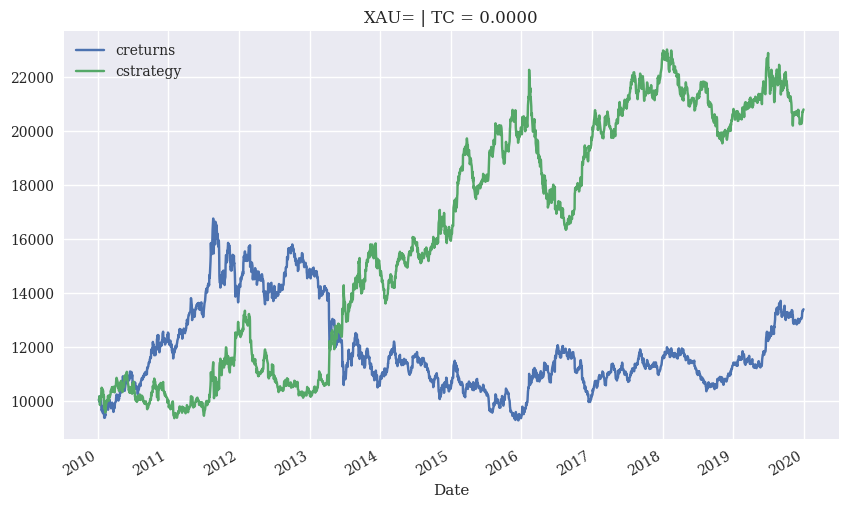

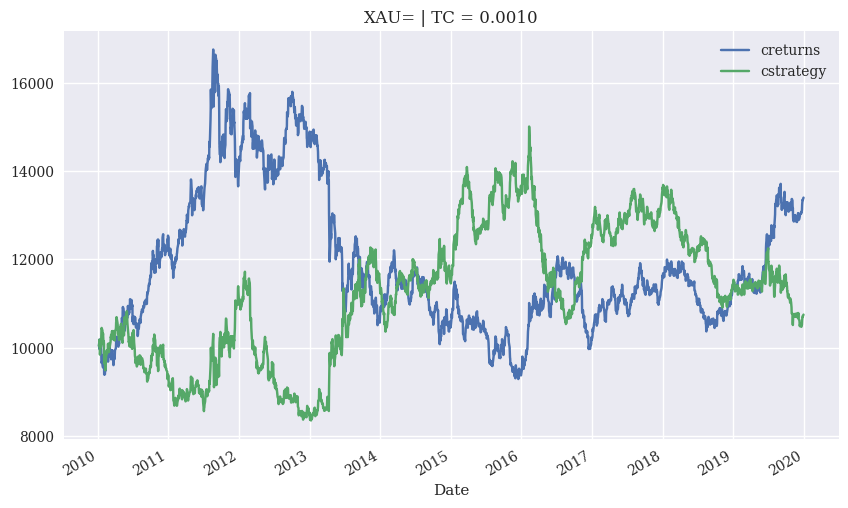

In [113]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Momentum-Based Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd


class MomVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    momentum-based trading strategies.

    Attributes
    ==========
    symbol: str
       RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the momentum-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw

    def run_strategy(self, momentum=1):
        ''' Backtests the trading strategy.
        '''
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['return'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['return']
        # determine when a trade takes place
        data.dropna(inplace=True)
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * \
            data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    # Instantiates an object of the backtesting class defining the starting capital 
    # to be 10,000 USD and the proportional transaction costs to be zero.
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31',
                                10000, 0.0)
    # print(mombt.run_strategy())
    print(mombt.run_strategy(momentum=3))
    mombt.plot_results()

    # include transaction costs
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31',
                                10000, 0.001)
    print(mombt.run_strategy(momentum=3))
    mombt.plot_results()

## Strategies Based on Mean Reversion
Roughly speaking, mean-reversion strategies rely on a reasoning that is the opposite of momentum strategies. If a financial instrument has performed “too well” relative to its trend, it is shorted, and vice versa. To put it differently, while (time series) momentum strategies assume a positive correlation between returns, mean-reversion strategies assume a negative correlation. Balvers et al. (2000) write:

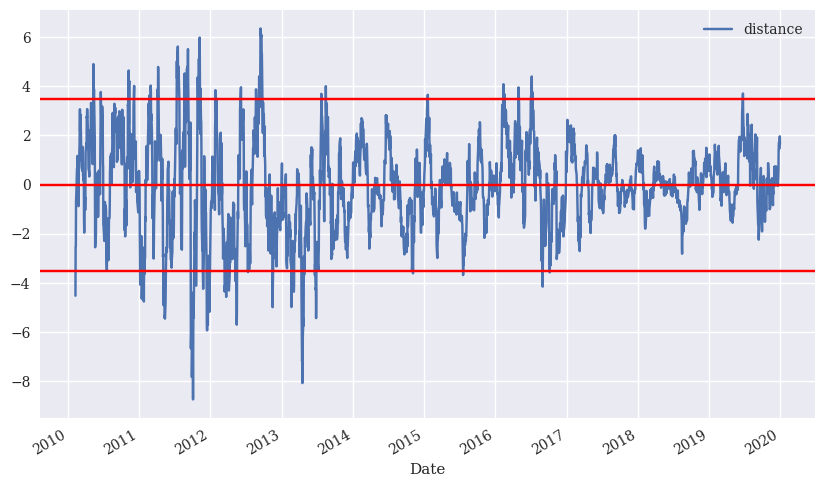

In [116]:
data = pd.DataFrame(raw['GDX'])
data.rename(columns={'GDX': 'price'}, inplace=True)
data['returns'] = np.log(data['price'] /
                                  data['price'].shift(1))
# The SMA parameter is defined
SMA = 25
# and SMA (“trend path”) is calculated
data['SMA'] = data['price'].rolling(SMA).mean()
# The threshold for the signal generation is defined
threshold = 3.5
# The distance is calculated for every point in time
data['distance'] = data['price'] - data['SMA']
# The distance values are plotted
data['distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

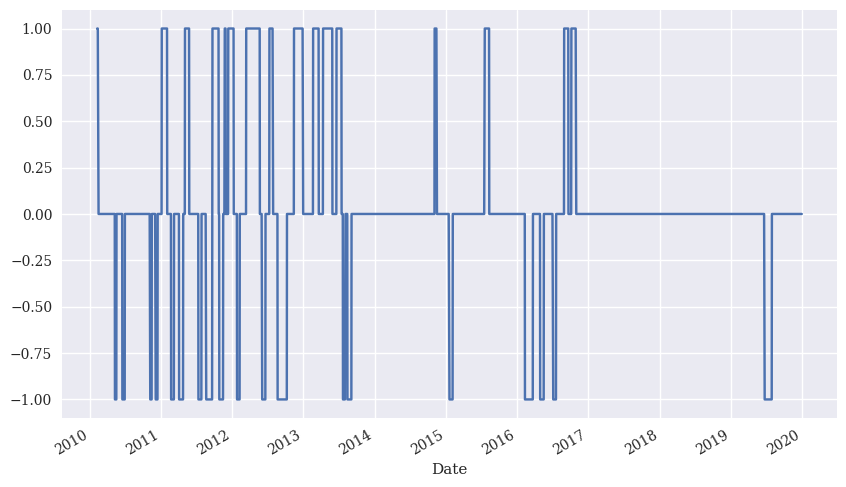

In [118]:
# Based on the differences and the fixed threshold values, positionings can 
# again be derived in vectorized fashion

# If the distance value is greater than the threshold value, go short (set –1 
# in the new column position), otherwise set NaN.
data['position'] = np.where(data['distance'] > threshold,
                                      -1, np.nan)
# If the distance value is lower than the negative threshold value, go long (set 1), 
# otherwise keep the column position unchanged
data['position'] = np.where(data['distance'] < -threshold,
                                      1, data['position'])
# If there is a change in the sign of the distance value, go market neutral (set 0), 
# otherwise keep the column position unchanged.
data['position'] = np.where(data['distance'] *
                      data['distance'].shift(1) < 0, 0, data['position'])
# Forward fill all NaN positions with the previous values; replace all remaining NaN values by 0.
data['position'] = data['position'].ffill().fillna(0)
# Plot the resulting positionings from the index position SMA on
data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                                         figsize=(10, 6));




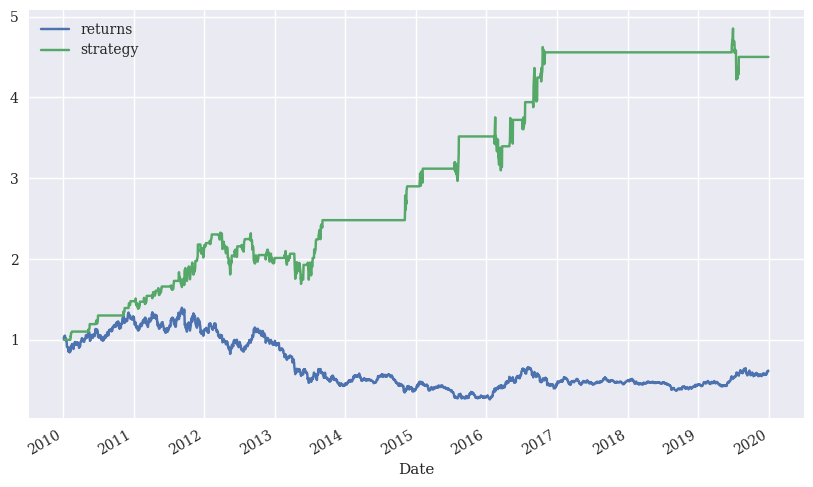

In [119]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
                  ).apply(np.exp).plot(figsize=(10, 6));

### Mean Reversion Backtesting Class

(18654.78, 11474.79)
(13104.59, 210.97)


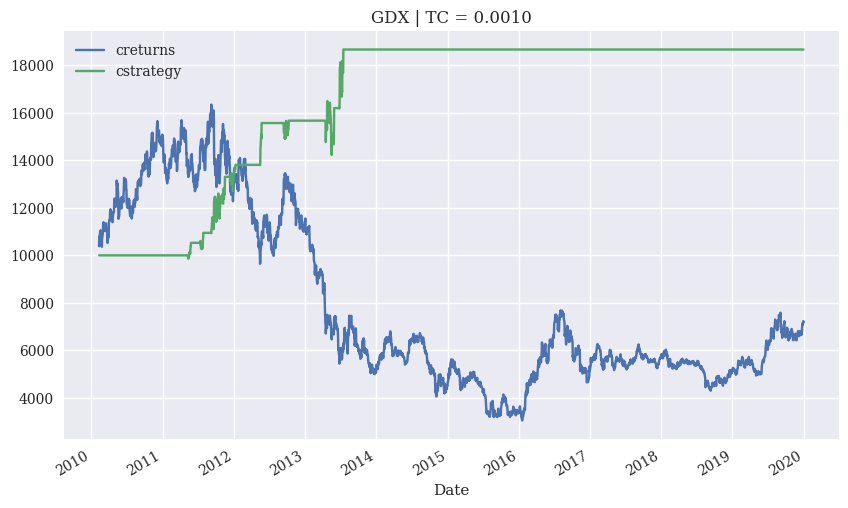

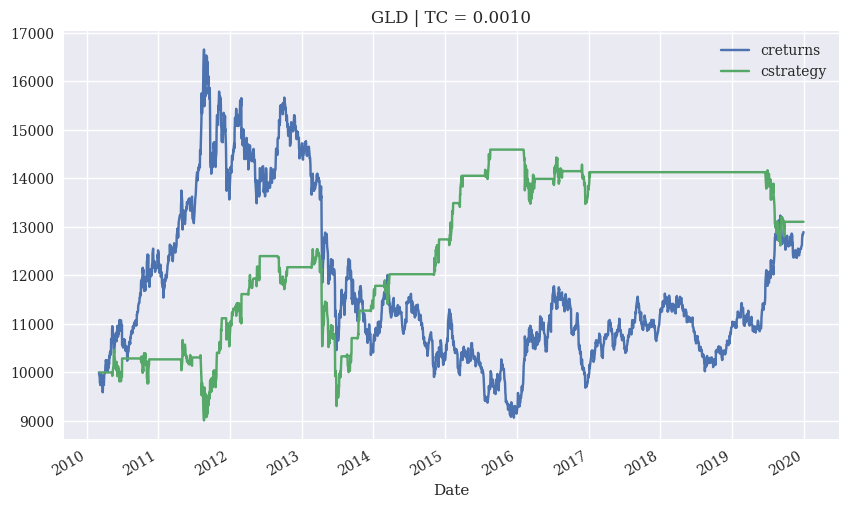

In [121]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Mean-Reversion Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
# from MomVectorBacktester import *


class MRVectorBacktester(MomVectorBacktester):
    ''' Class for the vectorized backtesting of
    mean reversion-based trading strategies.

    Attributes
    ==========
    symbol: str
        RIC symbol with which to work
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the mean reversion-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def run_strategy(self, SMA, threshold):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['sma'] = data['price'].rolling(SMA).mean()
        data['distance'] = data['price'] - data['sma']
        data.dropna(inplace=True)
        # sell signals
        data['position'] = np.where(data['distance'] > threshold,
                                    -1, np.nan)
        # buy signals
        data['position'] = np.where(data['distance'] < -threshold,
                                    1, data['position'])
        # crossing of current price and SMA (zero distance)
        data['position'] = np.where(data['distance'] *
                                    data['distance'].shift(1) < 0,
                                    0, data['position'])
        data['position'] = data['position'].ffill().fillna(0)
        data['strategy'] = data['position'].shift(1) * data['return']
        # determine when a trade takes place
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * \
            data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * \
            data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)


if __name__ == '__main__':
    # mrbt = MRVectorBacktester('GDX', '2010-1-1', '2020-12-31',
    #                           10000, 0.0)
    # print(mrbt.run_strategy(SMA=25, threshold=5))
    # mrbt.plot_results()
    
    mrbt = MRVectorBacktester('GDX', '2010-1-1', '2020-12-31',
                              10000, 0.001)
    print(mrbt.run_strategy(SMA=25, threshold=5))
    mrbt.plot_results()
    
    mrbt = MRVectorBacktester('GLD', '2010-1-1', '2020-12-31',
                              10000, 0.001)
    print(mrbt.run_strategy(SMA=42, threshold=7.5))
    mrbt.plot_results()